In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import anndata
import scanpy as sc
import os

import matplotlib.pyplot as plt

sc.settings.n_jobs = 24
sc.settings.set_figure_params(dpi=180, dpi_save=300, frameon=False, figsize=(4, 4), fontsize=8, facecolor='white')

## cleanup downloaded data

downloaded from:
https://portal.brain-map.org/atlases-and-data/rnaseq/human-m1-10x


In [3]:
# Only run this for the first time!
overwrite = False
seq_ref_folder = r'\\10.245.74.158\Chromatin_NAS_8\MERFISH\human\10xM1'
# adata file
seq_raw_filename = os.path.join(seq_ref_folder, 'hM1_10x_raw.h5ad')
seq_processed_filename = os.path.join(seq_ref_folder, 'hM1_10x_processed.h5ad')
sel_seq_processed_filename = os.path.join(seq_ref_folder, 'sel_hM1_10x_processed.h5ad')

In [27]:
figure_folder = os.path.join(seq_ref_folder, 'Figures')
if not os.path.exists(figure_folder):
    print(f"Create figure_folder: {figure_folder}")
    os.makedirs(figure_folder)
else:
    print(f"Use figure_folder: {figure_folder}")

sc.settings.figdir = figure_folder

Create figure_folder: \\10.245.74.158\Chromatin_NAS_8\MERFISH\human\10xM1\Figures


In [8]:
# load metadata
metadata_df = pd.read_csv(os.path.join(seq_ref_folder, 'metadata.csv'), low_memory=False)#.set_index('sample_name')


In [6]:
# load counts
count_df = pd.read_csv(os.path.join(seq_ref_folder, 'matrix.csv'), low_memory=False).set_index('sample_name')


In [9]:
# assemble anndata
adata = sc.AnnData(count_df, dtype=np.float32)
adata.obs = adata.obs.merge(metadata_df, left_index=True, right_on='sample_name').set_index('sample_name')
adata.write(seq_raw_filename)

In [21]:
adata.obs['total_counts'] = adata.X.sum(1)
adata.obs['n_genes_by_counts'] = (adata.X > 0).sum(1)

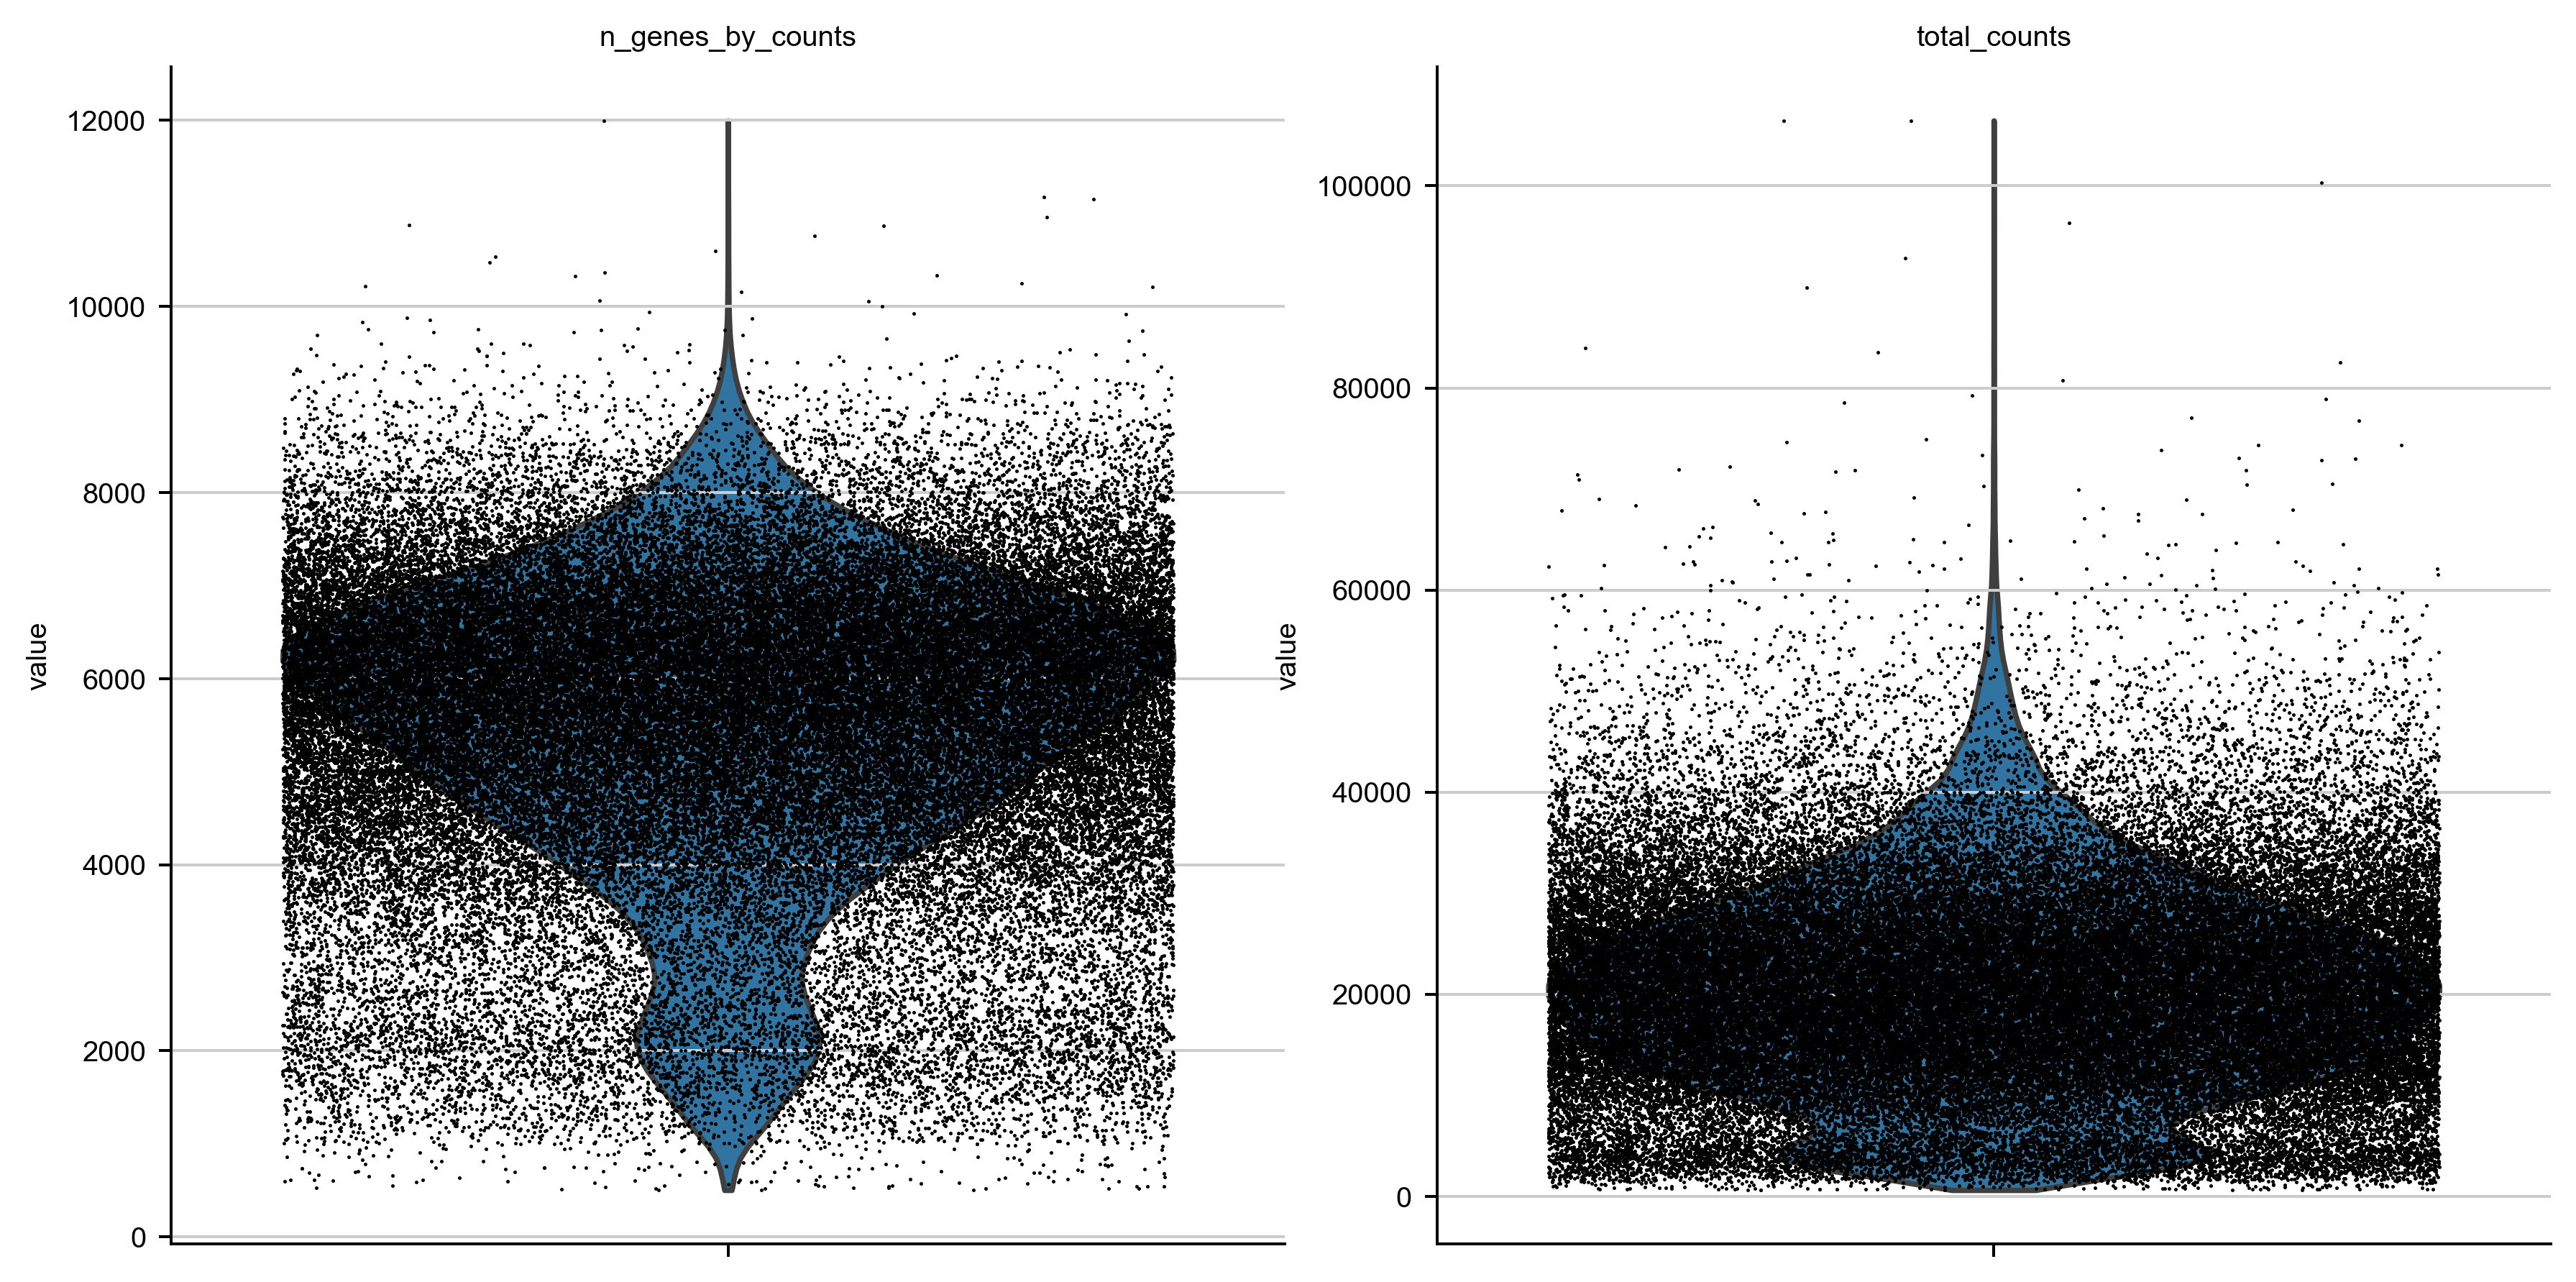

In [22]:
# A violin plot of some of the computed quality measures:
# - the number of genes expressed in the count matrix
# - the total counts per cell
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts'],
             jitter=0.4, multi_panel=True, )#save='_counts_after_filter.png')

In [ ]:
_total_median = np.median(adata.obs['total_counts'])
print(_total_median)
sc.pp.normalize_total(adata, target_sum=_total_median) 
# Logarithmize the data
sc.pp.log1p(adata)
# Regress out total counts
sc.pp.regress_out(adata, 'total_counts')
# Convert gene expressions to Z-scores
sc.pp.scale(adata, max_value=10)
# Principal component analysis
sc.tl.pca(adata, svd_solver='arpack')
# Plot the PCA results
sc.pl.pca(adata, save='_all_cells.png')

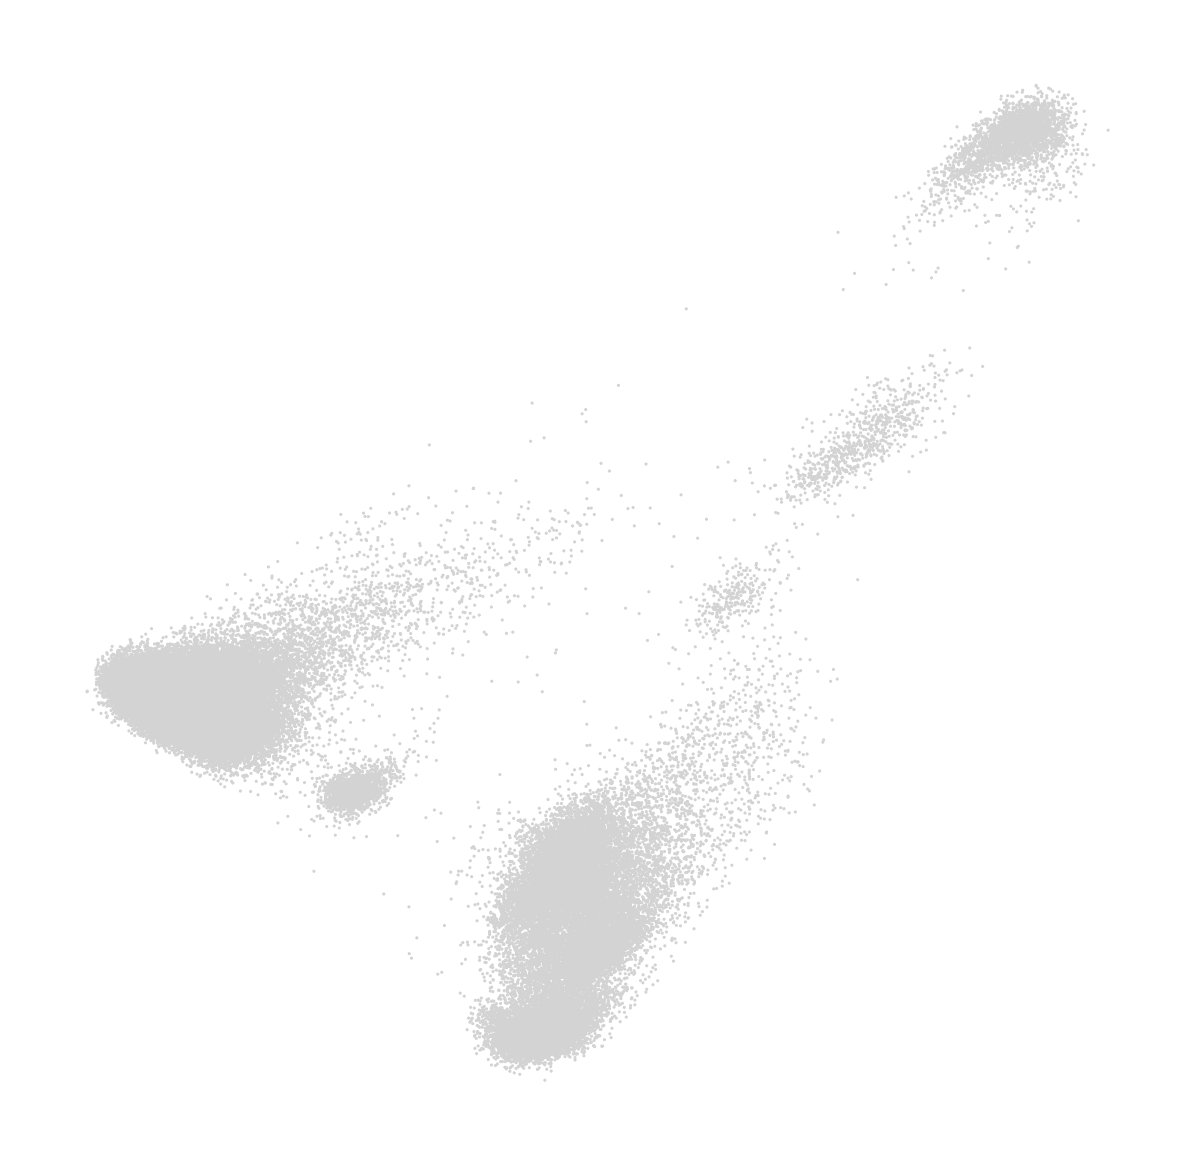

In [30]:
sc.pl.pca(adata, save='_all_cells.png')

In [31]:
%%time
# Computing the neighborhood graph
sc.pp.neighbors(adata, n_neighbors=5, n_pcs=30)
# Clustering
sc.tl.leiden(adata, resolution=0.8)

Wall time: 48.9 s


In [ ]:
%%time
# Embed with UMAP
sc.tl.umap(adata)

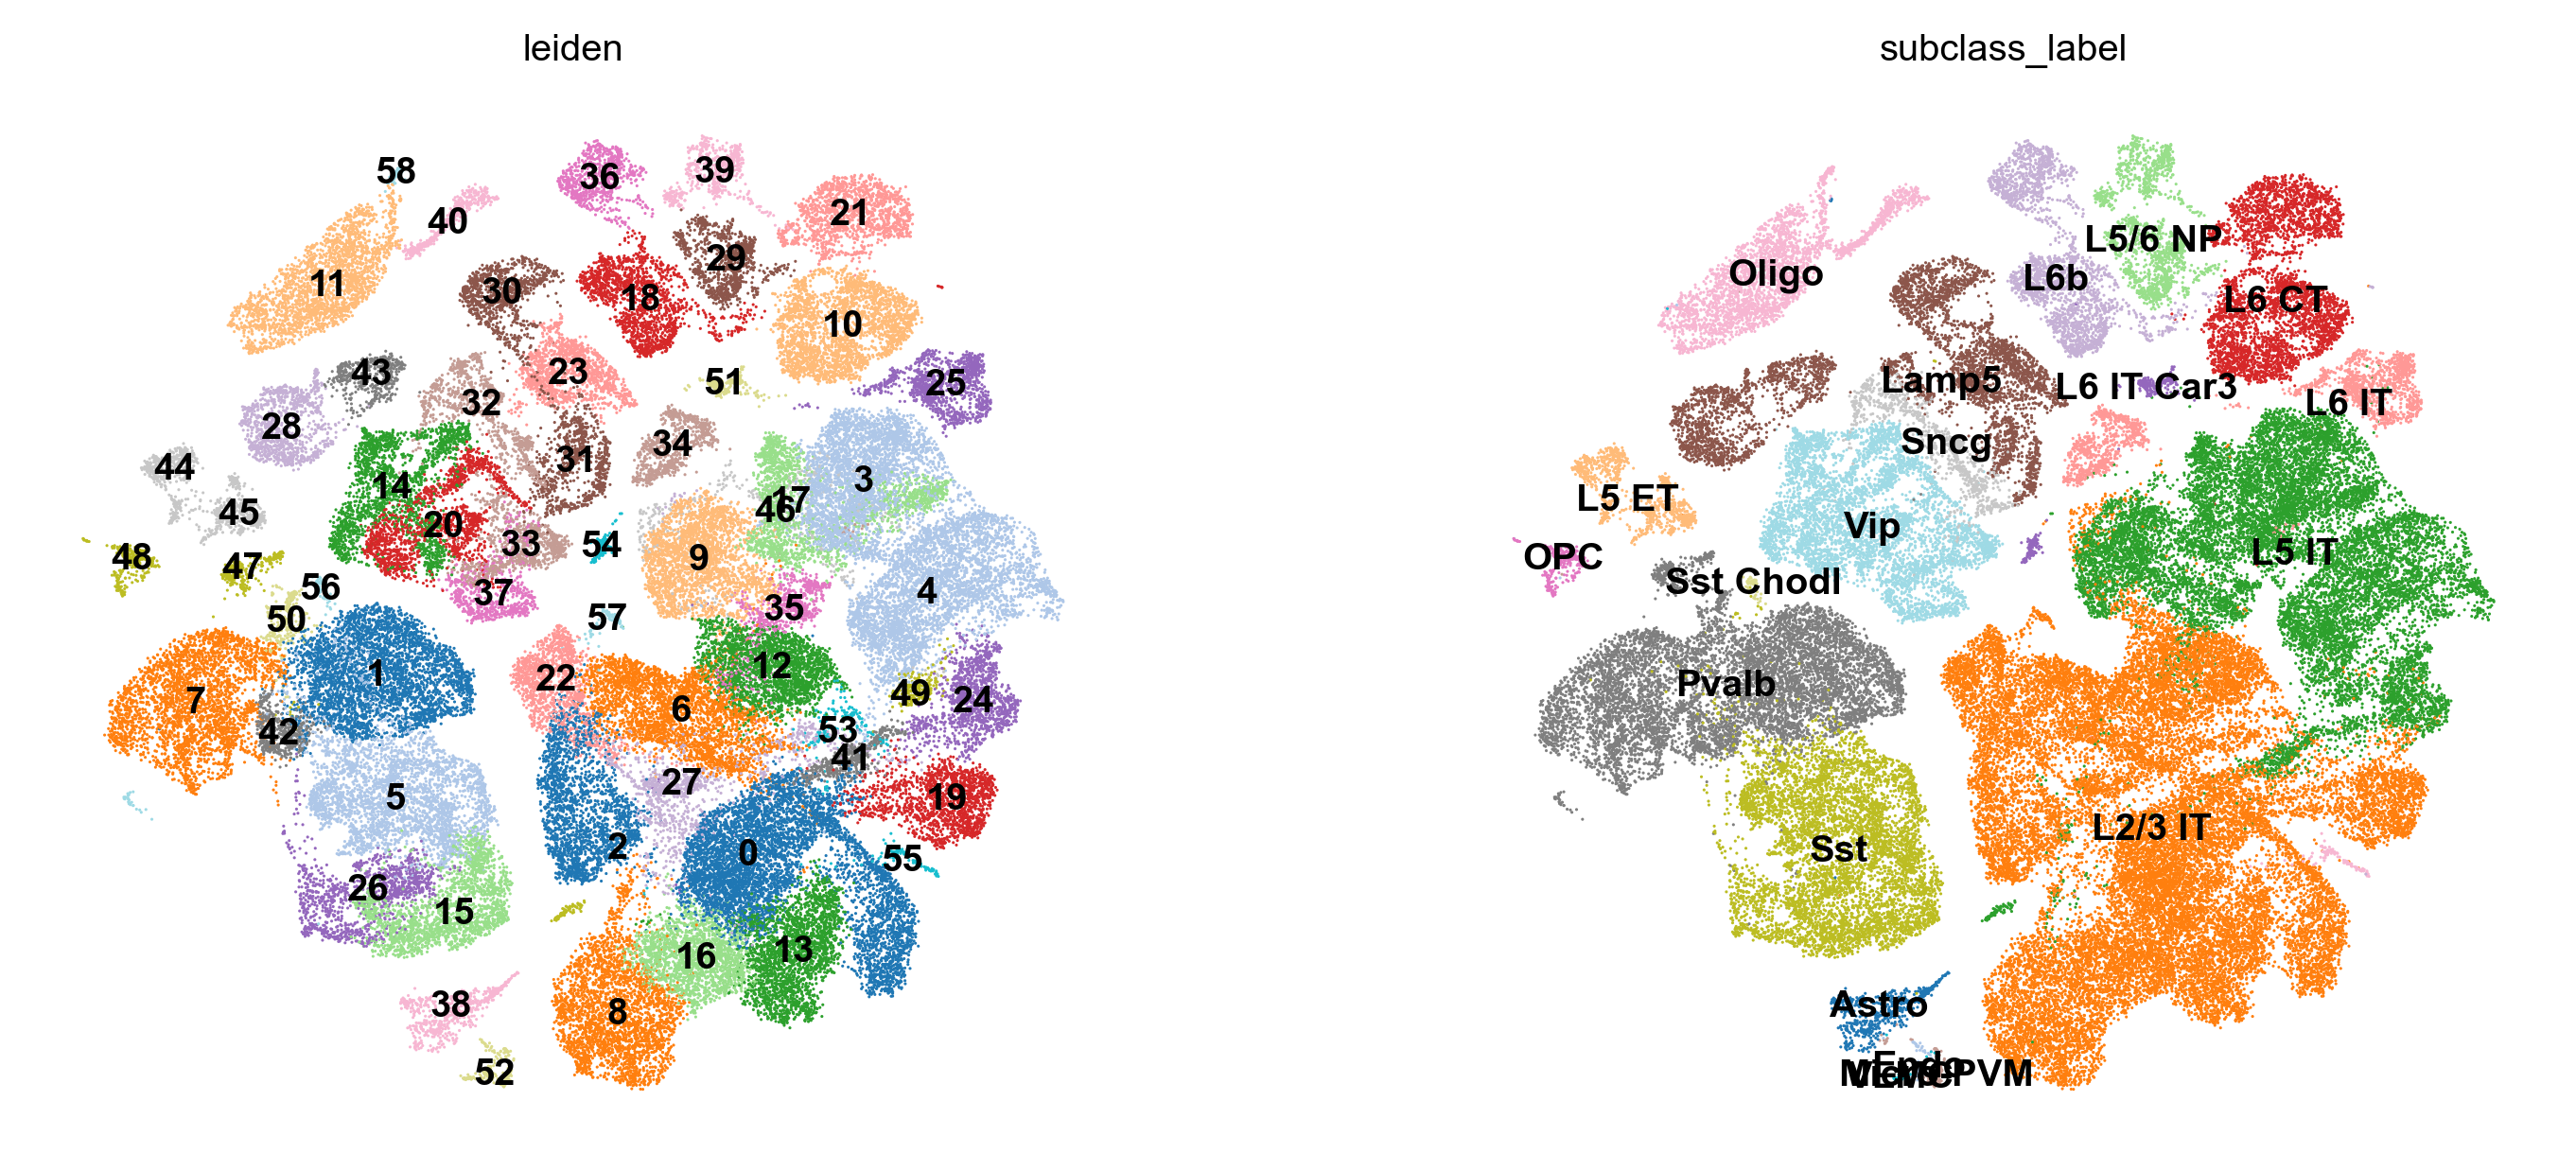

Wall time: 1min 3s


In [88]:
%%time
# Plot the UMAP
sc.pl.umap(adata, color=['leiden', 'subclass_label'], 
           legend_loc='on data',
           palette='tab20',
           save='_cluster.png',
           )

In [33]:
adata.write(seq_processed_filename)

# sel genes

In [34]:
merlin_output_master_folder = r'\\10.245.74.158\Chromatin_NAS_8\MERFISH\human'
save_filename = os.path.join(merlin_output_master_folder, 'hM1_hM1_summary', 'filtered_cluster_data.h5ad')

merfish_adata = sc.read(save_filename)

In [52]:
# match genes
gene_list = list(merfish_adata.var.index)
matched_genes = []
matched_gene_idx = []
for _gene in count_df.columns[1:]:
    if _gene in gene_list:
        matched_genes.append(_gene)
        matched_gene_idx.append(np.where(adata.var.index==_gene)[0][0])


In [85]:
# version 1
sel_adata = sc.AnnData(X=adata.X[:,np.array(matched_gene_idx)],
                       obs=adata.obs,
                       var=adata.var.iloc[np.array(matched_gene_idx)])

sc.pp.calculate_qc_metrics(sel_adata, percent_top=None, log1p=False, inplace=True)

sel_seq_raw_filename = os.path.join(seq_ref_folder, 'sel_hM1_10x_raw.h5ad')
print(f"Saving to file: {sel_seq_raw_filename}")
sel_adata.write(sel_seq_raw_filename)

Saving to file: \\10.245.74.158\Chromatin_NAS_8\MERFISH\human\10xM1\sel_hM1_10x_raw.h5ad


In [86]:
# version 2
sel_count_df = count_df[matched_genes]

sel_adata = sc.AnnData(sel_count_df, dtype=np.float32, obs=metadata_df.set_index('sample_name'))

sc.pp.calculate_qc_metrics(sel_adata, percent_top=None, log1p=False, inplace=True)

sel_seq_raw_filename = os.path.join(seq_ref_folder, 'sel_hM1_10x_raw.h5ad')
print(f"Saving to file: {sel_seq_raw_filename}")
sel_adata.write(sel_seq_raw_filename)

# Total-count normalize (library-size correct) the data matrix to 10,000 reads per cell
sc.pp.normalize_total(sel_adata, target_sum=1e2)
# Logarithmize the data
sc.pp.log1p(sel_adata)


Saving to file: \\10.245.74.158\Chromatin_NAS_8\MERFISH\human\10xM1\sel_hM1_10x_raw.h5ad


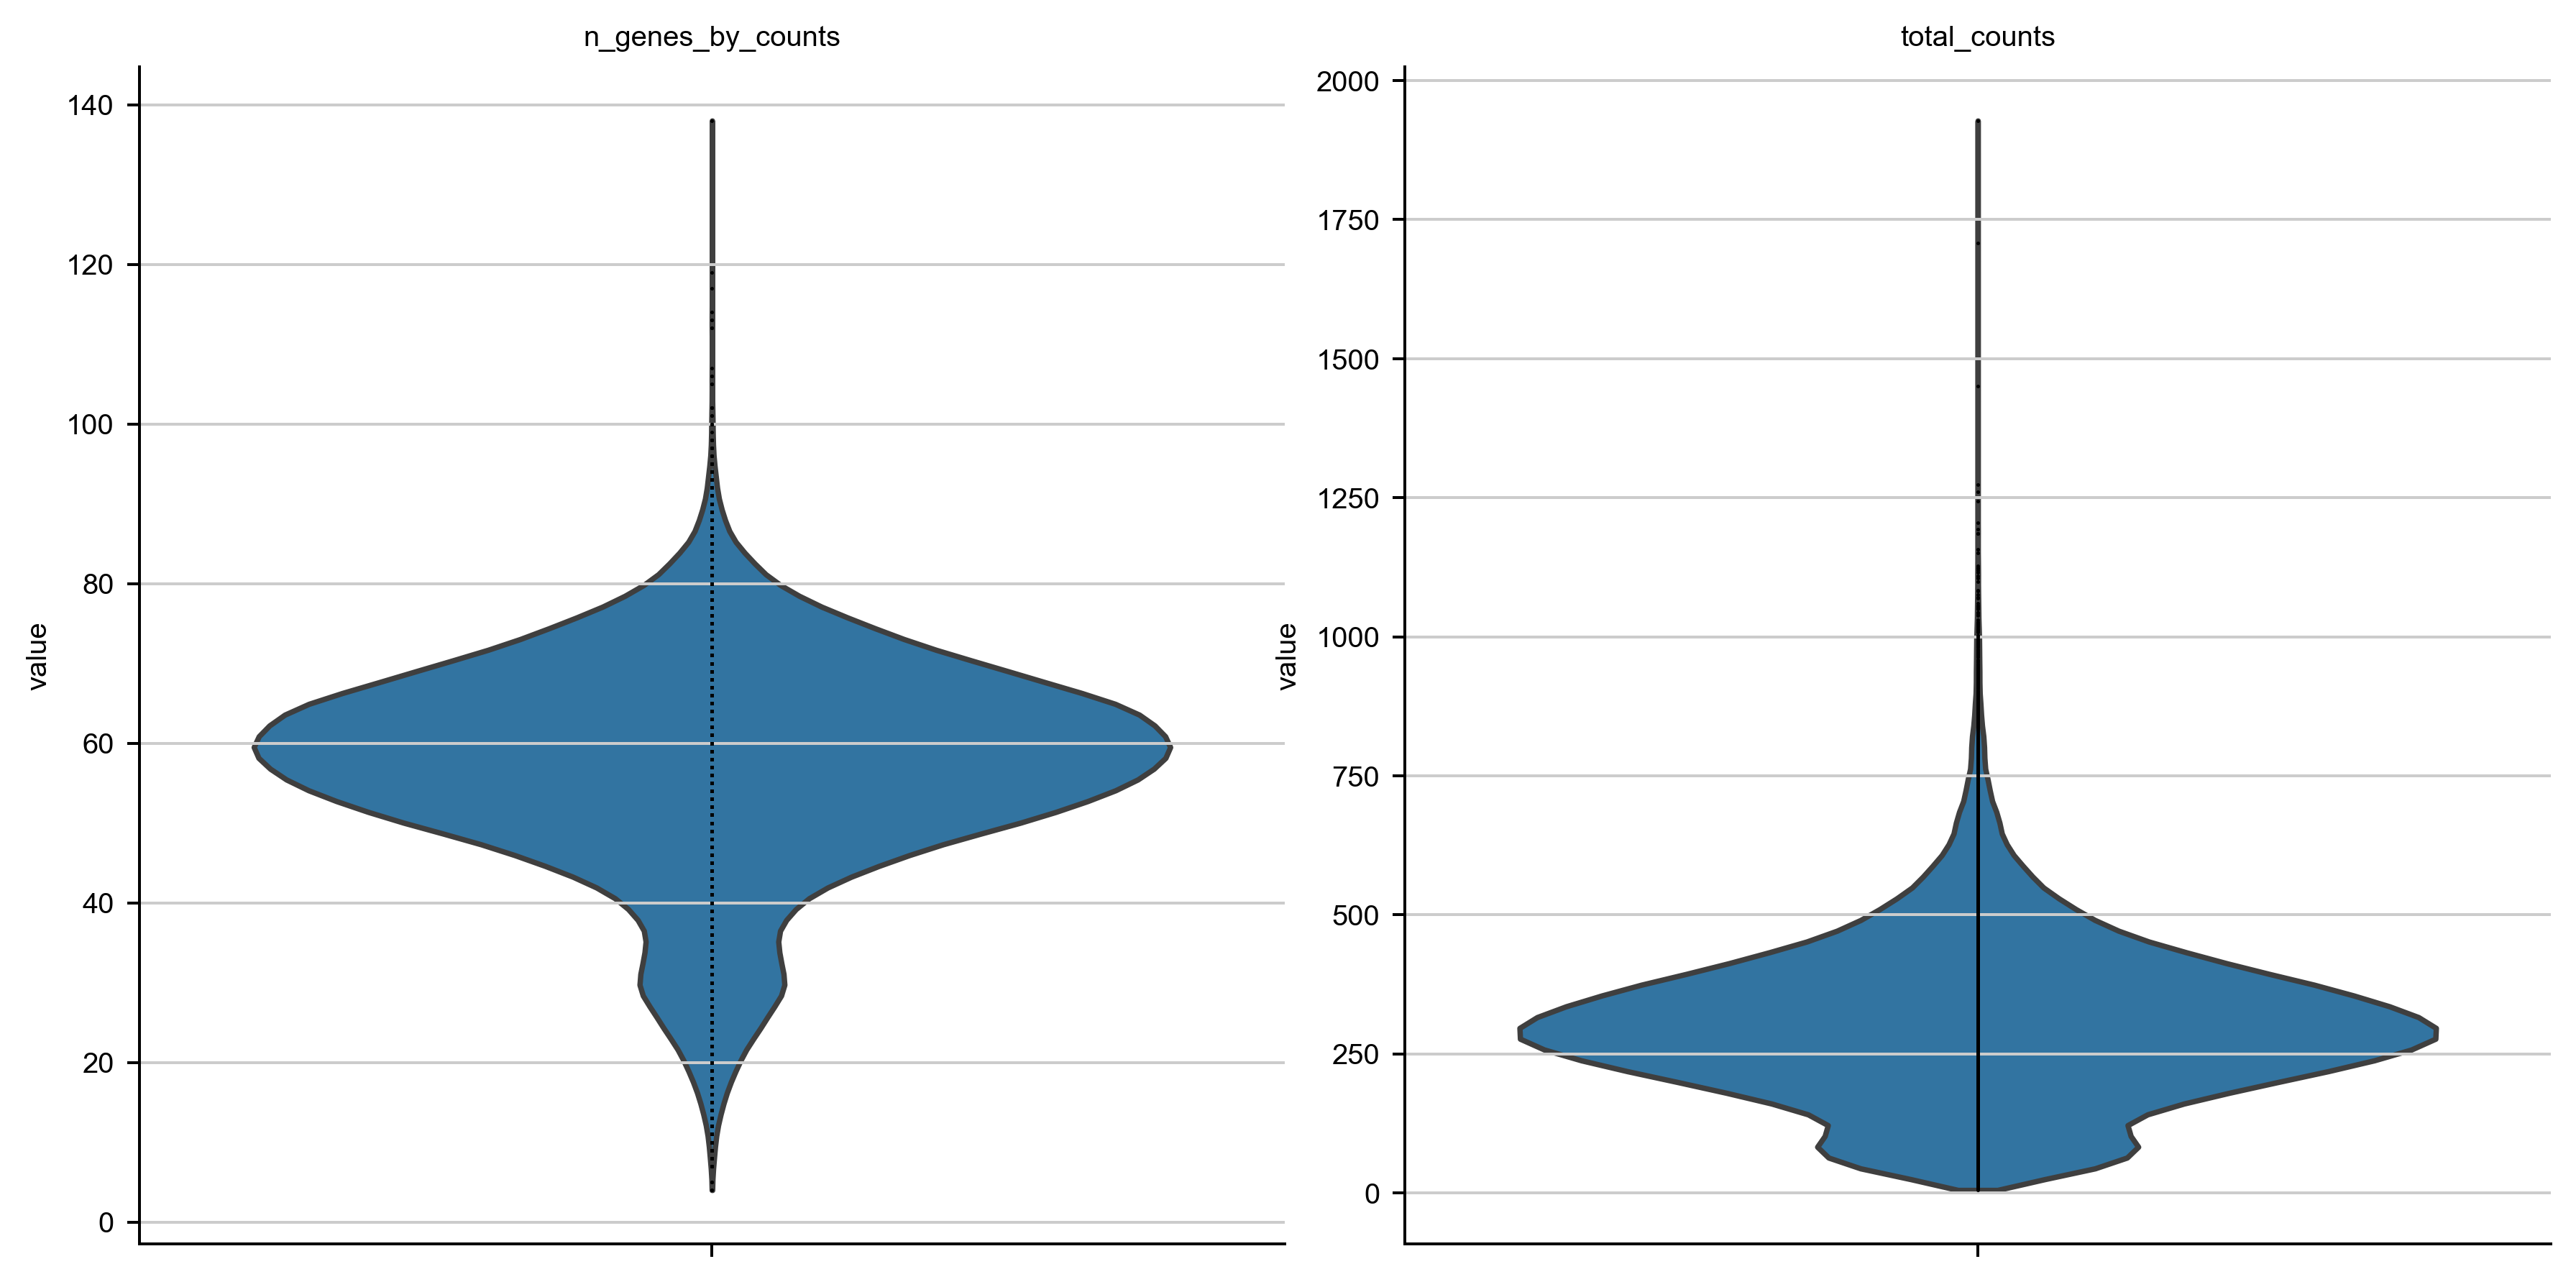

In [82]:
# A violin plot of some of the computed quality measures:
# - the number of genes expressed in the count matrix
# - the total counts per cell
sc.pl.violin(sel_adata, ['n_genes_by_counts', 'total_counts'],
             jitter=False, multi_panel=True, outlier=False, save='_sel_genes_counts_after_filter.png')

In [87]:
sel_seq_processed_filename = os.path.join(seq_ref_folder, 'sel_hM1_10x_processed.h5ad')
print(f"Saving to file: {sel_seq_processed_filename}")
sel_adata.write(sel_seq_processed_filename)

Saving to file: \\10.245.74.158\Chromatin_NAS_8\MERFISH\human\10xM1\sel_hM1_10x_processed.h5ad
